# KITTI Dataset visualization

This notebook was created as a tool to visualize the datasets generated with the GTAV LiDAR mod.

## Dataset structure

```
📦gta
┗ 📂training
  ┣ 📂calib
  ┃ ┣ 📜<file_id>.txt
  ┃ ┗ 📜 ...
  ┣ 📂image_2
  ┃ ┣ 📜<file_id>.png
  ┃ ┗ 📜 ...
  ┣ 📂label_2
  ┃ ┣ 📜<file_id>.txt
  ┃ ┗ 📜 ...
  ┗ 📂velodyne
    ┣ 📜<file_id>.bin
    ┗ 📜 ...
```

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mayavi.mlab as mlab
from skimage import io
import imageio
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from tqdm.notebook import trange, tqdm
from plyfile import PlyData, PlyElement

mlab.init_notebook()
#mlab.options.offscreen = True

Notebook initialized with ipy backend.


In [2]:
colors = sns.color_palette('Paired', 9 * 2)
names = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

N_SAMPLES = 160

## Visualizing the LiDAR point cloud with labels

In [26]:
def read_point_cloud(id, display=False):
    file_id = f'{id:06}'
    
    # load point clouds
    scan_dir = f'gta/training/velodyne/{file_id}.bin'
    scan = np.fromfile(scan_dir, dtype=np.float32).reshape(-1, 4)

    # load labels
    label_dir = f'gta/training/label_2/{file_id}.txt'
    with open(label_dir, 'r') as f:
        labels = f.readlines()

        fig = mlab.figure(bgcolor=(0, 0, 0), size=(1280, 720))
        # draw point cloud
        plot = mlab.points3d(scan[:, 0], scan[:, 1], scan[:, 2], mode="point", figure=fig)

    for line in labels:
        line = line.split()
        lab, _, _, _, _, _, _, _, h, w, l, x, y, z, rot = line
        h, w, l, x, y, z, rot = map(float, [h, w, l, x, y, z, rot])
        if lab != 'DontCare':
            x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
            y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
            z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]
            corners_3d = np.vstack([x_corners, y_corners, z_corners])  # (3, 8)

            # transform the 3d bbox from object coordiante to camera_0 coordinate
            R = np.array([[np.cos(rot), 0, np.sin(rot)],
                            [0, 1, 0],
                            [-np.sin(rot), 0, np.cos(rot)]])
            corners_3d = np.dot(R, corners_3d).T + np.array([x, y, z])

            # transform the 3d bbox from camera_0 coordinate to velodyne coordinate
            corners_3d = corners_3d[:, [2, 0, 1]] * np.array([[1, -1, -1]])


            def draw(p1, p2, front=1):
                mlab.plot3d([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]],
                            color=colors[names.index(lab) * 2 + front],
                            tube_radius=None, line_width=2, figure=fig)


            # draw the upper 4 horizontal lines
            draw(corners_3d[0], corners_3d[1], 0)  # front = 0 for the front lines
            draw(corners_3d[1], corners_3d[2])
            draw(corners_3d[2], corners_3d[3])
            draw(corners_3d[3], corners_3d[0])

            # draw the lower 4 horizontal lines
            draw(corners_3d[4], corners_3d[5], 0)
            draw(corners_3d[5], corners_3d[6])
            draw(corners_3d[6], corners_3d[7])
            draw(corners_3d[7], corners_3d[4])

            # draw the 4 vertical lines
            draw(corners_3d[4], corners_3d[0], 0)
            draw(corners_3d[5], corners_3d[1], 0)
            draw(corners_3d[6], corners_3d[2])
            draw(corners_3d[7], corners_3d[3])

    mlab.view(azimuth=180, elevation=60, distance=100, focalpoint=(0,0,0))
    mlab.savefig(filename=f'images/pc/{file_id}_labels.png')

    if display:
        return mlab.test_plot3d()
    else:
        mlab.close()

### Visualizing a single point cloud in KITTI format

In [27]:
pc = read_point_cloud(101, display=True)
pc

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\x00\x00\x00\x02\xd0\x08\x02\x00\x00\x00@\x1fJ\x0…

### Save a png screenshot for all the samples in KITTI format

In [9]:
for i in trange(N_SAMPLES):
    read_point_cloud(i)

### Make a gif from all the png images

In [10]:
fps = 1

images = []
for file_id in trange(N_SAMPLES):
    filename = f'images/pc/{file_id:06}_labels.png'
    images.append(imageio.imread(filename))

imageio.mimsave('gif/pc.gif', images, fps=fps)

## Verifying the match between the LiDAR point cloud and the front camera image

In [11]:
%%capture out

def cloud2img(id):
    file_id = f'{id:06}'

    # load point clouds
    scan_dir = f'gta/training/velodyne/{file_id}.bin'
    scan = np.fromfile(scan_dir, dtype=np.float32).reshape(-1, 4)

    # load image
    img = np.array(io.imread(f'gta/training/image_2/{file_id}.png'), dtype=np.int32)

    # load labels
    with open(f'gta/training/label_2/{file_id}.txt', 'r') as f:
        labels = f.readlines()

    # load calibration file
    with open(f'gta/training/calib/{file_id}.txt', 'r') as f:
        lines = f.readlines()
        P2 = np.array(lines[2].strip().split(' ')[1:], dtype=np.float32).reshape(3, 4)
        R0 = np.array(lines[4].strip().split(' ')[1:], dtype=np.float32).reshape(3, 3)
        V2C = np.array(lines[5].strip().split(' ')[1:], dtype=np.float32).reshape(3, 4)

    fig = plt.figure(figsize=(12, 6))
    # draw image
    plt.imshow(img)

    # transform the pointcloud from velodyne coordiante to camera_0 coordinate
    scan_hom = np.hstack((scan[:, :3], np.ones((scan.shape[0], 1), dtype=np.float32))) # [N, 4]
    scan_C0 = np.dot(scan_hom, np.dot(V2C.T, R0.T)) # [N, 3]

    # transform the pointcloud from camera_0 coordinate to camera_2 coordinate
    scan_C0_hom = np.hstack((scan_C0, np.ones((scan.shape[0], 1), dtype=np.float32))) # [N, 4]
    scan_C2 = np.dot(scan_C0_hom, P2.T) # [N, 3]
    scan_C2_depth = scan_C2[:, 2]
    scan_C2 = (scan_C2[:, :2].T / scan_C2[:, 2]).T

    # remove points outside the image
    inds = scan_C2[:, 0] > 0
    inds = np.logical_and(inds, scan_C2[:, 0] < img.shape[1])
    inds = np.logical_and(inds, scan_C2[:, 1] > 0)
    inds = np.logical_and(inds, scan_C2[:, 1] < img.shape[0])
    inds = np.logical_and(inds, scan_C2_depth > 0)

    plt.scatter(scan_C2[inds, 0], scan_C2[inds, 1], c=-scan_C2_depth[inds], alpha=0.5, s=1, cmap='viridis')

    # fig.patch.set_visible(False)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'images/camera/overlap/{file_id}_overlap.png', bbox_inches='tight');
    #plt.show()

### Visualizing a single camera image overlapping the KITTI point cloud

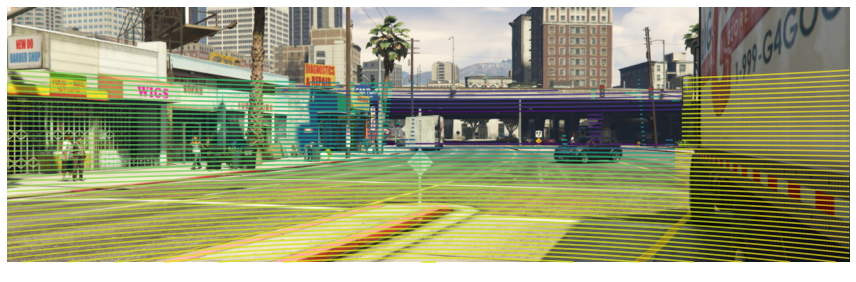

In [14]:
cloud2img(101)

### Create png images of the image and point cloud overlapped for all samples

In [12]:
%%capture out

for i in trange(N_SAMPLES):
    cloud2img(i)

### Make a gif from all the images

In [13]:
fps = 1

images = []
for file_id in trange(N_SAMPLES):
    filename = f'images/camera/overlap/{file_id:06}_overlap.png'
    images.append(imageio.imread(filename))

imageio.mimsave('gif/overlap.gif', images, fps=fps)

In [16]:
def plot_ply(ply):
    '''
    Plot vertices and triangles from a PlyData instance. Assumptions:
        `ply' has a 'vertex' element with 'x', 'y', and 'z'
            properties;
        `ply' has a 'face' element with an integral list property
            'vertex_indices', all of whose elements have length 3.
    '''
    vertex = ply['vertex']

    (x, y, z) = (vertex[t] for t in ('x', 'y', 'z'))

    mlab.points3d(x, y, z, color=(1, 1, 1), mode='point')

    if 'face' in ply:
        tri_idx = ply['face']['vertex_indices']
        triangles = numpy.vstack(tri_idx)
        mlab.triangular_mesh(x, y, z, triangles,
                             color=(1, 0, 0.4), opacity=0.5)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\x00\x00\x00\x02\xd0\x08\x02\x00\x00\x00@\x1fJ\x0…

## Visualizing the driving progress in both views

<img src="gif/pc.gif" width="750" align="center">
<img src="gif/overlap.gif" width="750" align="center">

## Comparing the PLY point cloud before and after converting to KITTI format

In [28]:
def show_ply(file_id):
    # Read .ply file
    input_file = f'LiDAR_PointCloud{file_id}/LiDAR_PointCloud.ply'

    plydata = PlyData.read(input_file)

    pts_x = plydata.elements[0].data['x']
    pts_y = plydata.elements[0].data['y']
    pts_z = plydata.elements[0].data['z']

    fig = mlab.figure(bgcolor=(0, 0, 0), size=(1280, 720))

    #given a set of points pts [N,3] and a set of intensities [N,]
    mlab.points3d(pts_x, pts_y, pts_z, mode='point', figure=fig)
    mlab.view(azimuth=-90, elevation=60, distance=100, focalpoint=(0,0,0))
    return mlab.test_plot3d()

### Point cloud BEFORE conversion (in PLY format)

In [31]:
pc = show_ply(101)
pc

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\x00\x00\x00\x02\xd0\x08\x02\x00\x00\x00@\x1fJ\x0…

### Point cloud AFTER converting to KITTI (bin file)

We can see a rotation after the conversion. The azimuth value for the original PC is -90º while the new one is being shown with a 180º azimuth. Also, the ID of the point clouds doesn't match the original and there were only 165 samples from the original 200 after the conversion.

In [30]:
pc = read_point_cloud(3, display=True)
pc

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\x00\x00\x00\x02\xd0\x08\x02\x00\x00\x00@\x1fJ\x0…